<a href="https://colab.research.google.com/github/jfkiviaho/toml/blob/master/colab_notebooks/beam_training_strats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
The purpose of this script is to investigate different training strategies for
physics-informed machine learning and their impact on the solution of the
cantilevered beam structural model.

The model is defined as

             (EIw'')'' = 0 

in the domain [0, 1] and

    (EIw''(x = L)' + P = 0
          EIw''(x = L) = 0
             w'(x = 0) = 0
              w(x = 0) = 0

on the boundary.

The training strategies to be investigated are 
1. gradient descent with boundary conditions applied as exterior penalties;
2. Adam with boundary conditions applied as exterior penalties;
3. L-BFGS with boundary conditions applied as exterior penalties;
4. Augmented Lagrangian (with L-BFGS inner loop) with boundary conditions
   applied as constraints; and
5. SLSQP with boundary conditions applied as constraints.

'''
# Load required modules
import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.optimize import minimize

import numpy as np
import numpy.linalg as la

import time

# Set floating point precision in Keras to double
tf.keras.backend.set_floatx('float64')

# Set global random seed
# Note: this is a shortcut for getting reproducible results.
tf.random.set_seed(12345)

In [ ]:
# Define model
class Model(keras.Sequential):
    def __init__(self):
        '''
        Initialize model with parameters, collocation points, and network 
        topology
        
        '''
        super(Model, self).__init__()

        ########################################################################
        # Define the equation and discretization parameters
        ########################################################################
        self.EI = 1.0  # N*m^2, flexural rigidity
        self.P  = 1.0  # N, tip load
        self.L = 1.0   # m, length of bar

        self.num_pts = 101

        ########################################################################
        # Define collocation points
        ########################################################################
        # Define boundary points and domain points
        x0 = np.array([0.0])
        x1 = np.array([self.L])
        self.bnd_pts = np.array([x0, x1])

        self.dom_pts = np.linspace(x0, x1, self.num_pts)

        # Normalize boundary points and domain points (maps x -> X)
        self.mu = self.dom_pts.mean()
        self.sigma = self.dom_pts.std()

        self.bnd_pts_norm = tf.constant((self.bnd_pts - self.mu)/self.sigma)
        self.dom_pts_norm = tf.constant((self.dom_pts - self.mu)/self.sigma)

        ########################################################################
        # Define the topology of the neural network
        ########################################################################
        # Add first layer
        input_layer = keras.layers.Dense(units=1, input_shape=[1])
        self.add(input_layer)

        # Add hidden layers
        hidden_layer1 = keras.layers.Dense(units=10, activation=tf.nn.tanh)
        self.add(hidden_layer1)
        
        hidden_layer2 = keras.layers.Dense(units=10, activation=tf.nn.tanh)
        self.add(hidden_layer2)

        # Add last layer
        output_layer = keras.layers.Dense(units=1)
        self.add(output_layer)

        # Addition of layers creates model parameters. Take current list of
        # model parameters and create lists of stitch and partition indices to
        # be used in converting between TensorFlow's representation of the
        # parameters and the 1D numpy array that an external optimizer will use
        self.shapes = tf.shape_n(self.trainable_variables)
        self.num_tensors = len(self.shapes)

        count = 0 
        self.stitch_ind = []
        self.partit_ind = []

        for i, shape in enumerate(self.shapes):
            num_elems = np.product(shape)
            self.stitch_ind.append(
                    tf.reshape(
                        tf.range(
                            count, 
                            count + num_elems,
                            dtype=tf.int32
                        ),
                        shape
                    )
                )
            self.partit_ind.extend([i]*num_elems)
            count += num_elems

        ########################################################################
        # Define optimization parameters and data
        ########################################################################
        self.max_iters = 10**3  # maximum num. of unconstrained opt. iterations
        self.tol_loss  = 1e-6   # loss function tolerance

        # Weights for exterior penalty formulations of loss function
        self.gamma1 = 1.0
        self.gamma2 = 1.0
        self.gamma3 = 1.0
        self.gamma4 = 1.0

        # Optimization history arrays
        self.iters = [0]
        self.res_hist = [self.eval_res().numpy()]
        self.bc_hist = [
                [self.eval_bnd_cnd1().numpy()],
                [self.eval_bnd_cnd2().numpy()],
                [self.eval_bnd_cnd3().numpy()],
                [self.eval_bnd_cnd4().numpy()]
            ]

        return

    def convert_numpy_array_to_vars(self, params_array):
        '''
        Convert 1D NumPy array with parameter values to a list of TensorFlow
        variables with appropriate shapes
        
        '''
        train_params = tf.dynamic_partition(
                params_array,
                self.partit_ind,
                self.num_tensors
            )

        return train_params
    
    def convert_vars_to_numpy_array(self, params_list):
        '''
        Convert a list of TensorFlow Variable objects (either the model 
        parameters or the gradient of a function w.r.t the model parameters) to
        a 1D NumPy array
        
        '''
        # If an output has no graph dependence on an input, TensorFlow will
        # output None for for the derivative of the output w.r.t. that input.
        # Replace None with the appropriately sized zero tensor for this case
        for i, (shape, param) in enumerate(zip(self.shapes, params_list)):
            if param is None:
                params_list[i] = tf.zeros(shape, dtype=tf.float64)

        params_tensor = tf.dynamic_stitch(
                self.stitch_ind,
                params_list
            )

        return params_tensor.numpy()

    def eval_res(self):
        '''
        Evaluate residual of governing equation
        
        Returns
        -------
        res: TensorFlow tensor
            evaluation of residual
        
        '''
        # Give normalized domain collocation points a more compact name
        X = self.dom_pts_norm
        
        # Evaluate residual of governing equation
        with tf.GradientTape() as t1:
            t1.watch(X)

            with tf.GradientTape() as t2:
                t2.watch(X)

                with tf.GradientTape() as t3:
                    t3.watch(X)

                    with tf.GradientTape() as t4:
                        t4.watch(X)
                        w = self.__call__(X)
                
                    w_X = t4.gradient(w, X)

                w_XX = t3.gradient(w_X, X)

            w_XXX = t2.gradient(w_XX, X)

        w_XXXX = t1.gradient(w_XXX, X)

        # Apply the chain rule
        dXdx = 1/self.sigma
        w_xxxx = w_XXXX*dXdx**4
        
        # Compute residual
        res = tf.reduce_sum(
                tf.square(
                    self.EI*w_xxxx
                )
            )
        
        return res

    def eval_bnd_cnd1(self):
        '''
        Evaluate zero-displacement boundary condition
        
        Returns
        -------
        bnd_cnd: TensorFlow tensor
            boundary condition violation

        '''
        # Extract left boundary point
        X0 = tf.slice(self.bnd_pts_norm, [0,0], [1,1])

        # Evaluate solution at left boundary point
        w_0 = self.__call__(X0)

        # Compute boundary condition violation
        bnd_cnd = tf.reduce_sum(tf.square(w_0))

        return bnd_cnd

    def eval_bnd_cnd2(self):
        '''
        Evaluate the zero slope boundary condition
        
        Returns
        -------
        bnd_cnd: TensorFlow tensor
            boundary condition violation

        '''
        # Extract left boundary point
        X0 = tf.slice(self.bnd_pts_norm, [0,0], [1,1])

        # Evaluate derivative of the solution at right boundary point
        with tf.GradientTape() as t:
            t.watch(X0)
            w_0 = self.__call__(X0)

        w_X_0 = t.gradient(w_0, X0)
        
        # Apply chain rule
        dXdx = 1/self.sigma
        w_x_0 = w_X_0*dXdx

        # Compute boundary condition violation
        bnd_cnd = tf.reduce_sum(tf.square(w_x_0))

        return bnd_cnd

    def eval_bnd_cnd3(self):
        '''
        Evaluate zero-moment boundary condition
        
        Returns
        -------
        bnd_cnd: TensorFlow tensor
            boundary condition violation

        '''
        # Extract right boundary point
        XL = tf.slice(self.bnd_pts_norm, [1,0], [1,1])

        # Evaluate solution at left boundary point
        with tf.GradientTape() as t1:
            t1.watch(XL)

            with tf.GradientTape() as t2:
                t2.watch(XL)
                w_L = self.__call__(XL)

            w_X_L = t2.gradient(w_L, XL)

        w_XX_L = t1.gradient(w_X_L, XL)

        # Apply chain rule
        dXdx = 1/self.sigma
        w_xx_L = w_XX_L*dXdx**2

        # Compute boundary condition violation
        bnd_cnd = tf.reduce_sum(tf.square(self.EI*w_xx_L))

        return bnd_cnd

    def eval_bnd_cnd4(self):
        '''
        Evaluate the tip load boundary condition
        
        Returns
        -------
        bnd_cnd: TensorFlow tensor
            boundary condition violation

        '''
        # Extract right boundary point
        XL = tf.slice(self.bnd_pts_norm, [1,0], [1,1])

        # Evaluate solution at left boundary point
        with tf.GradientTape() as t1:
            t1.watch(XL)

            with tf.GradientTape() as t2:
                t2.watch(XL)

                with tf.GradientTape() as t3:
                    t3.watch(XL)
                    w_L = self.__call__(XL)

                w_X_L = t3.gradient(w_L, XL)

            w_XX_L = t2.gradient(w_X_L, XL)

        w_XXX_L = t1.gradient(w_XX_L, XL)

        # Apply chain rule
        dXdx = 1/self.sigma
        w_xxx_L = w_XXX_L*dXdx**3

        # Compute boundary condition violation
        bnd_cnd = tf.reduce_sum(tf.square(self.EI*w_xxx_L + self.P))

        return bnd_cnd

    def train_with_gradient_descent(self):
        '''
        Train the neural network using a loss function that enforces the
        boundary conditions using exterior penalties and the gradient descent
        optimizer built into TensorFlow

        '''
        # Define optimizer
        init_learn_rate = 0.01
        opt = tf.optimizers.SGD(learning_rate=init_learn_rate)

        self.count = 0
        loss = 1

        while self.count < self.max_iters and loss > self.tol_loss:
            with tf.GradientTape() as t:
                # Compute the loss function
                res = self.eval_res()
                bc1 = self.eval_bnd_cnd1()
                bc2 = self.eval_bnd_cnd2()
                bc3 = self.eval_bnd_cnd3()
                bc4 = self.eval_bnd_cnd4()

                loss = res \
                       + self.gamma1*bc1 \
                       + self.gamma2*bc2 \
                       + self.gamma3*bc3 \
                       + self.gamma4*bc4

            # Compute the loss function gradient and update the parameters
            grad = t.gradient(loss, self.trainable_variables)
            opt.apply_gradients(zip(grad, self.trainable_variables))

            self.count += 1
            print('iter: {}'.format(self.count))
            print('loss: {}'.format(loss.numpy()))
            print()

            # Record optimization history
            self.iters.append(self.count)
            self.res_hist.append(res.numpy())
            self.bc_hist[0].append(bc1.numpy())
            self.bc_hist[1].append(bc2.numpy())
            self.bc_hist[2].append(bc3.numpy())
            self.bc_hist[3].append(bc4.numpy())

        return

    def train_with_adam(self):
        '''
        Train the neural network using a loss function the enforces the
        boundary conditions using exterior penalties and the Adam optimizer
        built into TensorFlow

        '''
        # Define optimizer
        opt = tf.optimizers.Adam()

        self.count = 0
        loss = 1

        while self.count < self.max_iters and loss > self.tol_loss:
            with tf.GradientTape() as t:
                # Compute the loss function
                res = self.eval_res()
                bc1 = self.eval_bnd_cnd1()
                bc2 = self.eval_bnd_cnd2()
                bc3 = self.eval_bnd_cnd3()
                bc4 = self.eval_bnd_cnd4()

                loss = res \
                       + self.gamma1*bc1 \
                       + self.gamma2*bc2 \
                       + self.gamma3*bc3 \
                       + self.gamma4*bc4

            # Compute the loss function gradient and update the parameters
            grad = t.gradient(loss, self.trainable_variables)
            opt.apply_gradients(zip(grad, self.trainable_variables))

            self.count += 1
            print('iter: {}'.format(self.count))
            print('loss: {}'.format(loss.numpy()))
            print()

            # Record optimization history
            self.iters.append(self.count)
            self.res_hist.append(res.numpy())
            self.bc_hist[0].append(bc1.numpy())
            self.bc_hist[1].append(bc2.numpy())
            self.bc_hist[2].append(bc3.numpy())
            self.bc_hist[3].append(bc4.numpy())

        return

    def train_with_bfgs(self):
        '''
        Train the neural network using a loss function the enforces the
        boundary conditions using exterior penalties and the L-BFGS optimizer
        from SciPy
        
        '''
        # Define wrapper function for the residual evaluation, which is now the
        # objective function
        self.count = 0

        def f(p):
            # Set model parameters from input NumPy array
            train_params = self.convert_numpy_array_to_vars(p)

            for i, (shape, param) in enumerate(zip(self.shapes, train_params)):
                self.trainable_variables[i].assign(tf.reshape(param, shape))
            
            # Compute the loss function
            res = self.eval_res()
            bc1 = self.eval_bnd_cnd1()
            bc2 = self.eval_bnd_cnd2()
            bc3 = self.eval_bnd_cnd3()
            bc4 = self.eval_bnd_cnd4()

            loss = res \
                   + self.gamma1*bc1 \
                   + self.gamma2*bc2 \
                   + self.gamma3*bc3 \
                   + self.gamma4*bc4
            
            return loss.numpy()

        # Define wrapper function for gradient of residual w.r.t. parameters
        def gradf(p):
            # Set model parameters from input NumPy array
            train_params = self.convert_numpy_array_to_vars(p)

            for i, (shape, param) in enumerate(zip(self.shapes, train_params)):
                self.trainable_variables[i].assign(tf.reshape(param, shape))

            # Compute gradient and convert to NumPy array
            with tf.GradientTape() as t:
                # Compute the loss function
                res = self.eval_res()
                bc1 = self.eval_bnd_cnd1()
                bc2 = self.eval_bnd_cnd2()
                bc3 = self.eval_bnd_cnd3()
                bc4 = self.eval_bnd_cnd4()

                loss = res \
                       + self.gamma1*bc1 \
                       + self.gamma2*bc2 \
                       + self.gamma3*bc3 \
                       + self.gamma4*bc4

            grad_loss = t.gradient(loss, self.trainable_variables)
            grad_loss_array = self.convert_vars_to_numpy_array(grad_loss)

            # Print count of times gradient of residual has been evaluated
            self.count += 1
            print()
            print('iter:', self.count)
            print('loss:', loss.numpy())

            # Record optimization history
            self.iters.append(self.count)
            self.res_hist.append(res.numpy())
            self.bc_hist[0].append(bc1.numpy())
            self.bc_hist[1].append(bc2.numpy())
            self.bc_hist[2].append(bc3.numpy())
            self.bc_hist[3].append(bc4.numpy())

            return grad_loss_array

        # Extract initial point for optimizer
        p0 = self.convert_vars_to_numpy_array(self.trainable_variables)

        # Run optimizer
        ans = minimize(
                f, p0, method='L-BFGS-B', jac=gradf,
                options={
                    'maxiter': self.max_iters,
                    'ftol': self.tol_loss
                }
            )

        # Check if optimizer converged
        if not ans.success:
            print('Optimizer did not converge.')
            print('Terminated with status ', ans.status)
            print('Cause of termination:')
            print(ans.message)
            
        # Extract optimized parameters and set model
        p = ans.x
        opt_params = self.convert_numpy_array_to_vars(p)

        for i, (shape, param) in enumerate(zip(self.shapes, opt_params)):
            self.trainable_variables[i].assign(tf.reshape(param, shape))
        
        return

    def train_with_aug_lag(self):
        '''
        Train the neural network using a Augmented Lagrangian approach to the
        optimization of the residual and the enforcement of the boundary
        conditions. The unconstrained optimization in the inner loop of the
        Augment Lagrangian procedure is performed by the L-BFGS optimizer from
        SciPy
        
        '''
        # Define wrapper function for the residual evaluation, which is now the
        # objective function
        self.count = 0

        def loss(p, lam, r):
            # Set model parameters from input NumPy array
            train_params = self.convert_numpy_array_to_vars(p)

            for i, (shape, param) in enumerate(zip(self.shapes, train_params)):
                self.trainable_variables[i].assign(tf.reshape(param, shape))
            
            # Compute the loss function
            res = self.eval_res()
            bc1 = self.eval_bnd_cnd1()
            bc2 = self.eval_bnd_cnd2()
            bc3 = self.eval_bnd_cnd3()
            bc4 = self.eval_bnd_cnd4()

            loss = res \
                   + lam[0]*bc1 \
                   + lam[1]*bc2 \
                   + lam[2]*bc3 \
                   + lam[3]*bc4 \
                   + r*(bc1 + bc2 + bc3 + bc4)
            
            return loss.numpy()

        # Define wrapper function for gradient of residual w.r.t. parameters
        def loss_grad(p, lam, r):
            # Set model parameters from input NumPy array
            train_params = self.convert_numpy_array_to_vars(p)

            for i, (shape, param) in enumerate(zip(self.shapes, train_params)):
                self.trainable_variables[i].assign(tf.reshape(param, shape))

            # Compute gradient and convert to NumPy array
            with tf.GradientTape() as t:
                # Compute the loss function
                res = self.eval_res()
                bc1 = self.eval_bnd_cnd1()
                bc2 = self.eval_bnd_cnd2()
                bc3 = self.eval_bnd_cnd3()
                bc4 = self.eval_bnd_cnd4()

                loss = res \
                       + lam[0]*bc1 \
                       + lam[1]*bc2 \
                       + lam[2]*bc3 \
                       + lam[3]*bc4 \
                       + r*(bc1 + bc2 + bc3 + bc4)

            grad_loss = t.gradient(loss, self.trainable_variables)
            grad_loss_array = self.convert_vars_to_numpy_array(grad_loss)

            # Print count of times gradient of residual has been evaluated
            self.count += 1
            print()
            print('iter:', self.count)
            print('loss:', loss.numpy())

            # Record optimization history
            self.iters.append(self.count)
            self.res_hist.append(res.numpy())
            self.bc_hist[0].append(bc1.numpy())
            self.bc_hist[1].append(bc2.numpy())
            self.bc_hist[2].append(bc3.numpy())
            self.bc_hist[3].append(bc4.numpy())

            return grad_loss_array

        # Extract initial point for optimizer
        p0 = self.convert_vars_to_numpy_array(self.trainable_variables)

        # Initialize pseudo-Lagrange multipliers and penalty parameter
        lam = np.zeros(4, dtype=np.float64)
        dlam = np.ones(4, dtype=np.float64)

        r    = 1.0    # penalty parameter
        rmax = 1.0e4  # max. penalty parameter
        cr   = 2.0    # penalty parameter growth

        # Set constrained and unconstrained optimization parameters
        max_iter_con = 10**2           # max. num. of constrained opt. iter.
        max_iter_unc = self.max_iters  # max. num. of unconstrained opt. iter.
        tol_con      = 1.0e-4          # tolerance on norm of multiplier update

        it_con = 0

        while la.norm(dlam) > tol_con and it_con < max_iter_con:
            # Extract initial point for optimizer
            p0 = self.convert_vars_to_numpy_array(self.trainable_variables)

            # Run unconstrained optimizer
            f = lambda p: loss(p, lam, r)
            gradf = lambda p: loss_grad(p, lam, r)
            ans = minimize(
                    f, p0, method='L-BFGS-B', jac=gradf,
                    options={
                        'maxiter': self.max_iters,
                        'ftol': self.tol_loss
                    }
                )

            # Check if optimizer converged
            if not ans.success:
                print('Optimizer did not converge.')
                print('Terminated with status ', ans.status)
                print('Cause of termination:')
                print(ans.message)
                
            # Extract optimized parameters and set model
            p = ans.x
            opt_params = self.convert_numpy_array_to_vars(p)

            for i, (shape, param) in enumerate(zip(self.shapes, opt_params)):
                self.trainable_variables[i].assign(tf.reshape(param, shape))

            # Extract the constraint evaluations and update the multipliers and
            # penalty parameter
            cons_eval = np.array([
                    self.eval_bnd_cnd1().numpy(),
                    self.eval_bnd_cnd2().numpy(),
                    self.eval_bnd_cnd3().numpy(),
                    self.eval_bnd_cnd4().numpy()
                ], dtype=np.float64)
            dlam = 2.0*r*cons_eval
            lam += dlam
            r = min(cr*r, rmax)

            it_con += 1
            print()
            print()
            print('########################################')
            print('Constrained iteration number {}'.format(it_con))
            print('########################################')
            print()
        
        return

    def train_with_slsqp(self):
        '''
        Train the neural network using the SLSQP optimizer from SciPy
        
        '''
        # Define wrapper function for the residual evaluation, which is now the
        # objective function
        self.count = 0

        def f(p):
            # Set model parameters from input NumPy array
            train_params = self.convert_numpy_array_to_vars(p)

            for i, (shape, param) in enumerate(zip(self.shapes, train_params)):
                self.trainable_variables[i].assign(tf.reshape(param, shape))
            
            res = self.eval_res()
            
            return res.numpy()

        # Define wrapper function for gradient of residual w.r.t. parameters
        def gradf(p):
            # Set model parameters from input NumPy array
            train_params = self.convert_numpy_array_to_vars(p)

            for i, (shape, param) in enumerate(zip(self.shapes, train_params)):
                self.trainable_variables[i].assign(tf.reshape(param, shape))

            # Compute gradient and convert to NumPy array
            with tf.GradientTape() as t:
                res = self.eval_res()

            grad_res = t.gradient(res, self.trainable_variables)
            grad_res_array = self.convert_vars_to_numpy_array(grad_res)

            # Print count of times gradient of residual has been evaluated
            self.count += 1
            print()
            print('iter:', self.count)
            print('res: ', res.numpy())

            # Record optimization history
            self.iters.append(self.count)
            self.res_hist.append(res.numpy())

            return grad_res_array

        # Define wrapper function for boundary condition evaluations
        def g_k(k, p):
            # Set model parameters from input NumPy array
            train_params = self.convert_numpy_array_to_vars(p)

            for i, (shape, param) in enumerate(zip(self.shapes, train_params)):
                self.trainable_variables[i].assign(tf.reshape(param, shape))

            if   k == 1:
                bnd_cnd = self.eval_bnd_cnd1()
            elif k == 2:
                bnd_cnd = self.eval_bnd_cnd2()
            elif k == 3:
                bnd_cnd = self.eval_bnd_cnd3()
            elif k == 4:
                bnd_cnd = self.eval_bnd_cnd4()
            else:
                error_msg = 'No such boundary condition defined'
                raise ValueError(error_msg)

            return bnd_cnd.numpy()

        # Define wrapper function for boundary condition evaluation gradients
        def gradg_k(k, p):
            # Set model parameters from input NumPy array
            train_params = self.convert_numpy_array_to_vars(p)

            for i, (shape, param) in enumerate(zip(self.shapes, train_params)):
                self.trainable_variables[i].assign(tf.reshape(param, shape))

            # Compute gradient and convert to NumPy array
            with tf.GradientTape() as t:
                if   k == 1:
                    bnd_cnd = self.eval_bnd_cnd1()
                    self.bc_hist[k-1].append(bnd_cnd.numpy())
                elif k == 2:
                    bnd_cnd = self.eval_bnd_cnd2()
                    self.bc_hist[k-1].append(bnd_cnd.numpy())
                elif k == 3:
                    bnd_cnd = self.eval_bnd_cnd3()
                    self.bc_hist[k-1].append(bnd_cnd.numpy())
                elif k == 4:
                    bnd_cnd = self.eval_bnd_cnd4()
                    self.bc_hist[k-1].append(bnd_cnd.numpy())
                else:
                    error_msg = 'No such boundary condition defined'
                    raise ValueError(error_msg)

            grad_bnd_cnd = t.gradient(bnd_cnd, self.trainable_variables)
            grad_bnd_cnd_array = self.convert_vars_to_numpy_array(grad_bnd_cnd)
            
            print('bc{}: '.format(k), bnd_cnd.numpy())

            return grad_bnd_cnd_array

        # Define constraints for optimizer
        cons = [{'type': 'eq', 
                 'fun': lambda p: g_k(1,p), 
                 'jac': lambda p: gradg_k(1,p)},
                {'type': 'eq', 
                 'fun': lambda p: g_k(2,p), 
                 'jac': lambda p: gradg_k(2,p)},
                {'type': 'eq', 
                 'fun': lambda p: g_k(3,p), 
                 'jac': lambda p: gradg_k(3,p)},
                {'type': 'eq', 
                 'fun': lambda p: g_k(4,p), 
                 'jac': lambda p: gradg_k(4,p)}]

        # Extract initial point for optimizer
        p0 = self.convert_vars_to_numpy_array(self.trainable_variables)

        # Run optimizer
        ans = minimize(
                f, p0, method='SLSQP', jac=gradf, constraints=cons,
                options={'maxiter':1000}
            )

        # Check if optimizer converged
        if not ans.success:
            print('Optimizer did not converge.')
            print('Terminated with status ', ans.status)
            print('Cause of termination:')
            print(ans.message)
            
        # Extract optimized parameters and set model
        p = ans.x
        opt_params = self.convert_numpy_array_to_vars(p)

        for i, (shape, param) in enumerate(zip(self.shapes, opt_params)):
            self.trainable_variables[i].assign(tf.reshape(param, shape))
        
        return

def w(x):
    '''
    Analytical solution for cantilevered Euler-Bernoulli beam with load at end

    '''
    # Define dimensional parameters
    EI = 1.0  # N*m^2, flexural rigidity
    P =  1.0  # N, tip load on beam
    L = 1.0

    return -P*x**3/(6*EI) + 0.5*P*L*x**2

iter: 1
loss: 100.63256067204821

iter: 2
loss: 90.44113577746525

iter: 3
loss: 81.21007581277077

iter: 4
loss: 72.87103355733214

iter: 5
loss: 65.35702169651086

iter: 6
loss: 58.60266243728375

iter: 7
loss: 52.54431005400852

iter: 8
loss: 47.12059135215877

iter: 9
loss: 42.27287233543734

iter: 10
loss: 37.94563581820821

iter: 11
loss: 34.0868558886337

iter: 12
loss: 30.64831347087092

iter: 13
loss: 27.585703731455826

iter: 14
loss: 24.858583784227072

iter: 15
loss: 22.430247172613853

iter: 16
loss: 20.267551501141156

iter: 17
loss: 18.340709893505547

iter: 18
loss: 16.623057756952434

iter: 19
loss: 15.090806323263843

iter: 20
loss: 13.722792901424587

iter: 21
loss: 12.50023568443108

iter: 22
loss: 11.406498789942638

iter: 23
loss: 10.426871205618344

iter: 24
loss: 9.548361607165356

iter: 25
loss: 8.759509737588118

iter: 26
loss: 8.050214220591224

iter: 27
loss: 7.411576260764925

iter: 28
loss: 6.835758511347481

iter: 29
loss: 6.31585831988252

iter: 30
loss:

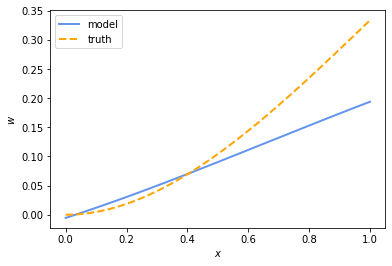

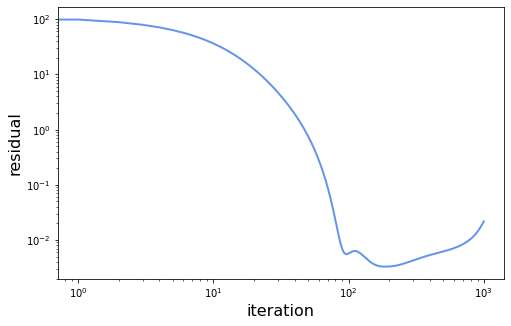

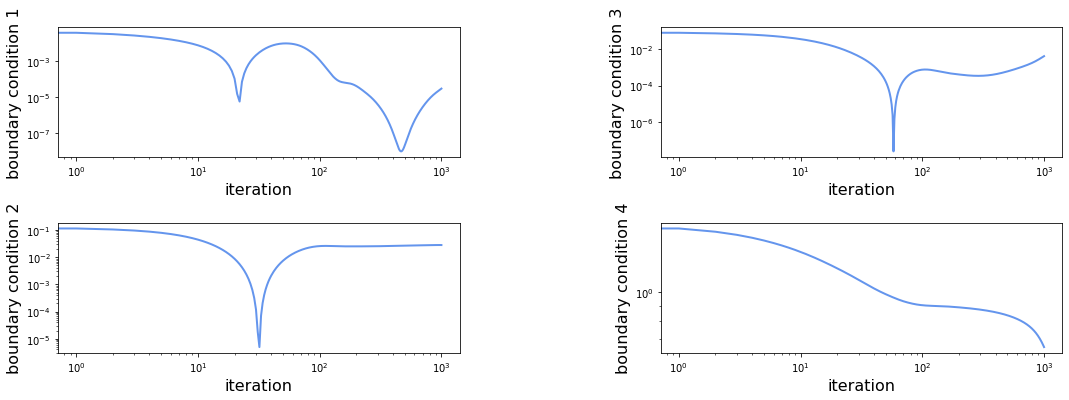

In [ ]:
if __name__ == '__main__':
    model = Model()
    tic = time.time()
    #model.train_with_gradient_descent()
    model.train_with_adam()
    #model.train_with_bfgs()
    #model.train_with_aug_lag()
    #model.train_with_slsqp()
    toc = time.time()
    wall_time = toc - tic

    # Plot comparison between model solution and analytical solution
    n = 1000
    lb = np.array([0.0])
    ub = np.array([1.0])
    x = np.linspace(lb, ub, n)
    w_pred = model.predict((x - model.mu)/model.sigma)
    w_true = w(x)

    fig, ax = plt.subplots()
    ax.plot(
            x, w_pred,
            color='cornflowerblue',
            linewidth=2,
            label='model'
        )
    ax.plot(
            x, w_true,
            color='orange',
            linewidth=2,
            linestyle='--',
            label='truth'
        )
    ax.legend()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$w$')

    # Plot residual his
    fig, ax = plt.subplots(figsize=(8,5))
    ax.loglog(
            model.iters, model.res_hist,
            color='cornflowerblue',
            linewidth=2,
        )
    ax.set_xlabel(r'iteration', fontsize=16)
    ax.set_ylabel(r'residual', fontsize=16)

    # Plot boundary condition violation histories
    fig, ax = plt.subplots(2, 2, figsize=(18,6))
    plt.subplots_adjust(
            hspace=0.5,  # height of blank space between subplots?
            wspace=0.5   # width of blank space between subplots?
        )
    for k in range(4):
        # Do some binary math to organize plots into a 2 x 2 grid
        i = (k & 1) >> 0
        j = (k & 2) >> 1

        ax[i,j].loglog(
                model.iters, model.bc_hist[k],
                color='cornflowerblue',
                linewidth=2,
            )
        ax[i,j].set_xlabel(r'iteration', fontsize=16)
        ax[i,j].set_ylabel(r'boundary condition {}'.format(k+1), fontsize=16)

    print()
    print('Model results')
    print('-------------')
    print('res:', model.eval_res().numpy())
    print('bc1:', model.eval_bnd_cnd1().numpy())
    print('bc2:', model.eval_bnd_cnd2().numpy())
    print('bc3:', model.eval_bnd_cnd3().numpy())
    print('bc4:', model.eval_bnd_cnd4().numpy())
    print()
    hrs = int(wall_time//3600)
    mns = int((wall_time - hrs*3600)//60)
    scs = wall_time - hrs*3600 - mns*60
    print(
            'Model trained in ' +
            '{0:02d}:{1:02d}:{2:6.3f} '.format(hrs, mns, scs) + 
            '(wall time)'
        )

    plt.show()